# AutoPCA - or ten ways to Solve a Problem in Pandas/Numpy

This is an actual problem that took me a few days to solve. I go through my own thinking and learning as I went. Along the way there are a number of very interesting and useful nuggets along the way that are worth knowing, and are not commonly known. Bear with me and I expect that it will be educational even if you are an old-timer, and even if you are not interested in Principal Components.

Some parts of this are about python and pandas, while others are about numpy and mathematics. Most of it would be useful for intermediate/advance data analysts.

I am going to be using 64bit Python 3.7.3, Pandas 0.25.3, and Numpy 1.17.3 on a Windows 10 machine.

In [1]:
import numpy as np
from numpy.random import random as rnd
import scipy
import scipy.linalg as la
import scipy.signal as spsig
from sklearn.decomposition import PCA

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
pd.show_versions()



INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
machine          : AMD64
processor        : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.9.0
pandas_datareader: None
bs4              : None
bottleneck       : 1.2.1
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matpl

## The Problem

I started out with a dataframe that had been measured every second, although some variables were very slowly changing. It was clearly extremely redundant, so my first thought was dimensionality reduction. The data covered some 5 months, so there were `5*30*24*60*60` or nearly 13 million rows, and about 140 columns. It was (dis-)organized as a set of csv files (more than 15GBs), one for each hour, grouped in directories of days, which were grouped in directories of months.

CSV files are large and reading them is slow, so the first task was to convert them to some compressed format. The problem is that the entire dataset is so big that the whole dataframe won't load into memory at once. 13million * 140 * 8 is over 14GBs, which is all the memory that I had.

Currently the file format that I find "best" is the `hdf` format, especially because support for it is already there in `pandas`. An `hdf` file can store multiple `pandas` data frames, in a compressed format with quite fast reads and writes. There are a number of compression options. I compressed the many GBs of directories and files into six separate dataframes, and put all the six dataframes into a single 3.75 GB `hdf` file.

## Preliminaries

Reading large amounts of data itself is a serious matter. Here are some invaluable techniques that were useful.

### Nugget 1. Read all CSV Files and Save in one Big HDF File

You might think that you need a number of loops to cover all the months, days, and hours, but the `glob` module collected all `csv` files scattered in a number of subdirectories, and is just a few lines.

    import pandas as pd
    import glob
    with pd.HDFStore(r'c:\PyProj\persecond\alldata.h5') as hdf:
        for n, file in enumerate(glob.glob(r"c:\PyProj\persecond\**\*.csv", recursive=True)):
            hdf[f'/d{n:05d}'] = pd.read_CSV(f)

Here an empty hdf file is created in line 3 if it doesn't exists, or is opened if it does. Then each csv file is stored as a separate dataframe and stored under a sequential key starting from `/d00000`. This file is not compressed, so you won't notice any significant reduction in size.

### Nugget 2. HDF files

As mentioned, a single dataframe would be too large to fit in memory, so instead we will break the single dataframe into six, where each one contains some 30 complete columns combining all the scattered dataframes.

As mentioned above `hdf` files are a nice fast and compressed format. If you simply want to save a single dataframe in a file, `dataframe.to_hdf(filepath, key, complevel, complib)` is easiest. To read a single dataframe, the command suffices `pd.read_hdf(filepath, key)`.

Since we are going to write multiple dataframe into one hdf file, it is more efficient to keep the file open during the entire process. The fourth line opens an hdf file for the duration of the `with` statement, and automatically closes it at the end. An open `hdf` file can be used just like a dictionary, to store a dataframe, just pick a unique `key` for each dataframe that your store. Note that this time, the `hdf` file is opened to write a compressed format (there are many to choose from, and this is usually a good choice but it is worth experimenting).

    ncol = 30
    with pd.HDFStore(r'c:\PyProj\persecond\alldata.h5', mode='r') as hdf:
        for n in range(6):
            with pd.HDFStore(r'c:\PyProj\persecond\sixdata.h5', complevel=9, complib='blosc:lz4') as six:
                df = pd.DataFrame()
                for key in hdf.keys():
                    df = df.append(hdf[key].iloc[:,n*ncol:(n+1)*ncol], ignore_index=True, sort=False)
                    six[f'/data{n}] = df

The method of writing an `hdf` file used here is the least flexible, but because of that it is the fastest and gets the most compression. See the `pandas` documentation on `hdf` [here](https://pandas.pydata.org/pandas-docs/stable/reference/io.html#hdfstore-pytables-hdf5).

Other methods allow adding rows or columns to stored datasets, loading partial datasets, etc. That way we can deal with datasets that are too big to fit in memory (See the long documentation for [pytables](http://www.pytables.org/usersguide/introduction.html)). Had we used that method, we could have stored the entire data in one table, but at the cost of slower read/writes and larger file size.

Since the csv files that I was using are huge (and contain proprietary information), they can't be shared. Instead we will create some fake data of the same size and shape, so that we can continue our experiments.

### Nugget 3. Setting Defaults

After working for a while, you begin to like output in a certain format, and you can customize things so that you don't have to do too much work to set your preferred defaults. I prefer to specify my defaults in a file that you include. This way it is explicit, rather than some autoloaded magic, and yet doesn't take too much effort. Here are some things worth setting at the start.

#### MatPlotLib

If you use `matplotlib`, you can globally set your preferred styles, colors, fonts etc at the start by using `plt.rcParams` as shown in line 1 of the box below. You can get a list of all possible parameters that can be set, as well as many more customization tips from the [documentation](https://matplotlib.org/3.1.1/tutorials/introductory/customizing.html).

All global preference can be overridden for an individual plot.

#### Numpy

Use `initial_defaults = np.get_printoptions()` to save the original values. Then you can 

    np.set_printoptions(precision, threshold, edgeitems, linewidth, supress, nanstr, infstr, formatter, sign, floatmode)

to specify your preferences, and restore back to the defaults by 
`np.set_printotions(initial_defaults)`.

#### Pandas

Similarly you can set global preferences for `pandas` output, like the number of digits, the maximum width of a dataframe display, etc, as documented [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html). As before, all global preference can be overridden for an individual display. For a fancier amount of styling you can see [this](https://mode.com/example-gallery/python_dataframe_styling/). We don't really show any use of these here, but it is very useful when needed.

After creating the data in `x`, we look at the entire series in the first plot, and zoom in on a random 180 second period in the second plot.

### Nugget 4. Using Context Managers

The `with` statement of Python is probably familiar in the context of using disk files. In general, a `with` block is essentially a constructor at the start to do the initial setup, and a destructor at the end to do all the cleanup. The preferences mentioned above can be set globally at the start, but sometimes we want to alter them for just a short duration, and then restore them to the original. Context managers are the best way to implement this action. Here is an example for setting print options for numpy arrays, and then using it to print an array.

Once again, there is much to learn here, and I would point you to the Python documentation.

In [3]:
plt.rcParams['figure.figsize'] = [16, 5]
def np_reset_printoptions():
    np.set_printoptions(precision=8, threshold=1000, edgeitems=3, linewidth=75, 
                        suppress=False, nanstr='nan', infstr='inf')


from contextlib import contextmanager

@contextmanager
def np_set_printoptions(fmt=None, *pargs, **dargs):
    """ Allows temporary setting of print options, and also has a shortcut
        for specifying a format by just saying for example:
        >>> with np_set_printoptions(fmt="{:10.5f}"):
    """
    if fmt is not None:
        dargs['formatter'] = {'all':lambda x: fmt.format(x)}
    previous = np.get_printoptions()
    np.set_printoptions(*pargs, **dargs)
    yield None
    np.set_printoptions(**previous)
    
np_reset_printoptions()
with np_set_printoptions(fmt='{:10.5f}'):
    print(np.arange(5.0))
print(np.arange(5.0))

[   0.00000    1.00000    2.00000    3.00000    4.00000]
[0. 1. 2. 3. 4.]


## Use Simulated data

Let's start by making a single feature, `x`, and use random numbers, but in a way that makes it random but smooth and slowly changing. We don't bother putting it as a `pandas.Series`, because we are not really going to use much of pandas abilities here.


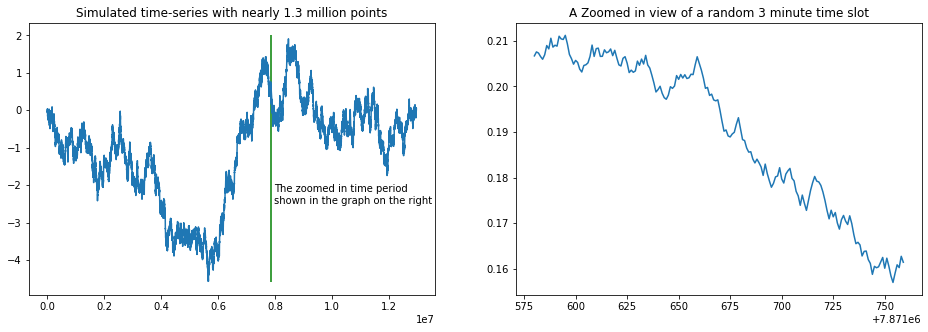

In [4]:
nrows = 5*30*24*60*60
np.random.seed(2)
x = 5e-3 * np.cumsum(np.cumsum(rnd(nrows)-0.5)/nrows + rnd(nrows) - 0.5)
x = x - x[-1]*np.arange(nrows)/nrows

rnd60 = int(rnd(1)*nrows//60)*60
plt.subplot(121)
plt.title("Simulated time-series with nearly 1.3 million points")
plt.plot(np.arange(0,len(x),300), x[::300])
plt.vlines(rnd60,-4.6,2, color="green")
plt.text(rnd60+1e5, -2.5, "The zoomed in time period\nshown in the graph on the right")
plt.subplot(122)
plt.title("A Zoomed in view of a random 3 minute time slot")
plt.plot(np.arange(rnd60, rnd60+180), x[rnd60:rnd60+180])


## Reshaping the Data

The data was sampled once every second. If we grouped periods of 60 seconds, and tried to summarize each minute by just a few numpbers, could we do a good job?

To make groups of of any size, we can use the `reshape` function. Note that we have to drop a few elements from the initial sequence, because `reshape` can't handle partial rows. The `%` refers to the `remainder` function, which is exactly how much would be left as a remainder (or the size of the partial row).


In [4]:
# Demo of what reshape does
a = np.arange(22)
for group in [4,7,11]:
    print(a[len(a) % group:].reshape(-1, group))
    print()


[[ 2  3  4  5]
 [ 6  7  8  9]
 [10 11 12 13]
 [14 15 16 17]
 [18 19 20 21]]

[[ 1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14]
 [15 16 17 18 19 20 21]]

[[ 0  1  2  3  4  5  6  7  8  9 10]
 [11 12 13 14 15 16 17 18 19 20 21]]



What if we decided to drop elements from the end of the sequence instead of the start? One solution that comes to mind is to replace line 4 above, with

    print(a[:-(len(a) % group)].reshape(-1, group))
    
which works perfectly for the first two cases, but fails for the last.
    

In [5]:
a = np.arange(22)
for group in [4,7,11]:
    print(a[:-(len(a) % group)].reshape(-1, group))
    print()


[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]

[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]]

[]



What happened ... and how to fix it? When we evaluate `len(x) % 11 == 22 % 11` it is the remainder of `22 / 11` which is 0. Now for a starting value of a range, `[0:]` is perfectly fine, but for an ending value negative zero as `[:-0]` is the same as 0, which will always return an empty array `[]`, where what we really wanted was the entire array.

### Nugget 5. Remove `n` elements from the end of an array

Here is a very common problem. You want to remove a calculated number `n` of elements from the end of an array `a`, where sometimes the number `n` can be zero. You could write:

    a[:-n] if n>0 else a
    
but this looks like a lot to write (especially if n is a computed expression). Here is an interesting alternative that I find myself using all too often:

    a[:-n or None]

Unfortunately, this is a bit cryptic, and I wish Python itself took care to devise a better alternative, but amongst all the other alternatives, I find this a bit magical, but the clearest. The `or` function checks the left argument `-n` and if it is **`True`** or non-zero, then that is the result (which is `-n` in this case), but if it is **`False`** or zero, then the right argument is the result (which is **`None`** in this case). A right limit of **`None`** means to go all the way to the end, so this works as you can see.

In [7]:
a = np.arange(22)
for group in [4,7,11]:
    print(a[:-(len(a) % group) or None].reshape(-1, group))
    print()
    

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]

[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]]

[[ 0  1  2  3  4  5  6  7  8  9 10]
 [11 12 13 14 15 16 17 18 19 20 21]]



## Dimensionality Reduction using PCA

One of the more standard techniques of reducing dimensionality is **Principal Components Analysis** (PCA) (sklearn documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). An example is best to illustrate, so imagine a tailor's list of measurements of sleeve, collar, chest, waist, ... What is interesting is that many stores carry shirts with just a single number to indicate the size. Given that number they estimate what all the others measurements ought to be. Store bought shirts never fit quite as well as a tailored shirt, unless you are a perfectly average person, but they are good enough for most people.

Similarly, given a large number of features (think tailor's measurements), PCA tries to create a few linear combinations of the features to create one or two components (think shirt size), such that we can reconstruct the original features by taking linear combinations of these components. The smaller the number of components, the higher the reconstruction error (the difference between the actual features and the features reconstructed from components). If, instead of just one number for size, we allowed two numbers for store shirts, one indicating an overall size, and one for a width kind of measure, then store bought shirts would be able to fit many more people with a better fit.

### PCA with just one Feature

Each feature (column) of my data is a time series, and my problem was to find the "appropriate sampling rate" for each feature. There are a number of ways to approach this problem. 
A statistical approach would look at the autocorrelation function, and the rate of its decay.
From a signals perspective, we could try to take a Fourier Transform of the time series, and find out at what frequencies most of the energy was located, and then sample as double that frequency or a bit more.

Instead of these methods, we are going instead to see if a few principal components can represent a large number of slowly changing points. To illustrate, let us consider the data broken into intervals of one minute each. Each interval contains 60 observations (one per second), and will be represented by a row of 60 numbers.
We will attempt to use PCA to compress each row to just a few components. Here is how we could answer the question.


In [5]:
# group x into rows of length 60 each (as explained in nugget 5)
x_minutes = x[:-(len(x) % 60) or None].reshape(-1, 60)

# compute Principal Components
pca = PCA(n_components=3).fit(x_minutes)
ev = pca.explained_variance_ratio_

with np_set_printoptions(fmt="{:9.6f}%"):
    print("             Explained variance:", ev * 100)
    print("Cumulative Unexplained variance:", (1 - np.cumsum(ev)) * 100)


             Explained variance: [99.998844%  0.000705%  0.000175%]
Cumulative Unexplained variance: [ 0.001156%  0.000451%  0.000276%]


The explained variance is a number between 0 and 1, which assigns how much of the data variation is explained by a single component. Usually these are listed from the highest to the lowest. The numbers are additive, so if we use all three components, then they would explain the sum of the three numbers.

The three numbers in the cumulative unexplained (or residual) variance is how much error remains after one, or two, or three components are used to reconstruct the data.

To understand what this means, we will compress each minute's 60 data points into just three numbers (components). Then we use these components to reconstruct the original data (brown colored line in the right graph below). It is not a perfect reconstruction. You can see the sudden jumps at the minute boundaries.

We do the same with just two components (green line in the right graph below), and finally with just one component. Obviously just one component does not do a very good job if you look very closely (blue line in the right graph below), but when you look at the overall picture, the error is hardly noticeable (few blue dots where the blue line peeks out from under the pink line, barely visible in the left graph below).

(216000, 3) There are 3 components for every 60 seconds.


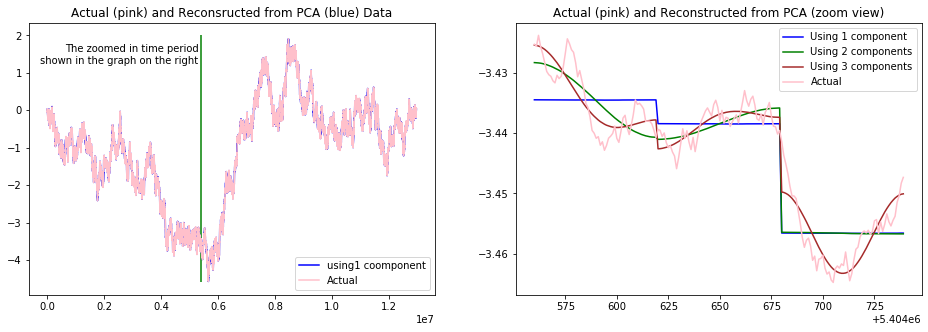

In [6]:
np.random.seed(1)
# convert the data to get all three components
components = pca.transform(x_minutes)
print(components.shape, "There are 3 components for every 60 seconds.")
# kill the second and third components, so we only have one component
onecomp = components.copy()
reconstructed_x3 = np.ravel(pca.inverse_transform(onecomp))
onecomp[:,2] = 0
reconstructed_x2 = np.ravel(pca.inverse_transform(onecomp))
onecomp[:,1] = 0
reconstructed_x1 = np.ravel(pca.inverse_transform(onecomp))
# now reconstruct an approximation to the original data from just that one component
rnd60 = int(rnd(1)*nrows//60)*60
plt.subplot(121)
plt.title("Actual (pink) and Reconsructed from PCA (blue) Data")
plt.plot(np.arange(0,len(x),300), reconstructed_x1[::300], color="blue", label="using1 coomponent")
plt.plot(np.arange(0,len(x),300), x[::300], color="pink", label="Actual")
plt.vlines(rnd60,-4.6,2, color="green")
plt.text(rnd60-1e5, 1.25, "The zoomed in time period\nshown in the graph on the right",
         horizontalalignment="right")
plt.legend(loc="lower right")
plt.subplot(122)
plt.title("Actual (pink) and Reconstructed from PCA (zoom view)")
plt.plot(np.arange(rnd60, rnd60+180), reconstructed_x1[rnd60:rnd60+180], color="blue", label="Using 1 component")
plt.plot(np.arange(rnd60, rnd60+180), reconstructed_x2[rnd60:rnd60+180], color="green", label="Using 2 components")
plt.plot(np.arange(rnd60, rnd60+180), reconstructed_x3[rnd60:rnd60+180], color="brown", label="Using 3 components")
plt.plot(np.arange(rnd60, rnd60+180), x[rnd60:rnd60+180], color="pink", label="Actual")
plt.legend()


## Log Likelihoods for Anomaly Detection

While we are here, it may be worth mentioning a tangent point. Finding one number that by itself can predict 60 is quite an impressive feat. But it relies on the fact that the data has some common patterns. If the data had been simply random, it would not be possible to compress even a little bit.

Another information available from a PCA is the "log-likelihood" of a sample. If I give some 60 numbers, how well can the components predict it. If the sample of 60 numbers comes from data with similar patterns, it should be easy to predict. If it does not follow the patterns of the data, then the prediction would not be so good.

Using the tailor analogy, if we did a PCA for a large Brazilian population, then we try to fit these shirts to some people from Nigeria, the fit might not be very good. Even among Nigerians, there may be individual that are different from the norm. Locating points where the fit is unusually bad is called anomaly detection.

So here, we obtain a "log-likelihood" score for each 60 second interval. The lower the score the more unusual the interval is.


The log liklihood at 168981 is 107.86891848885688.


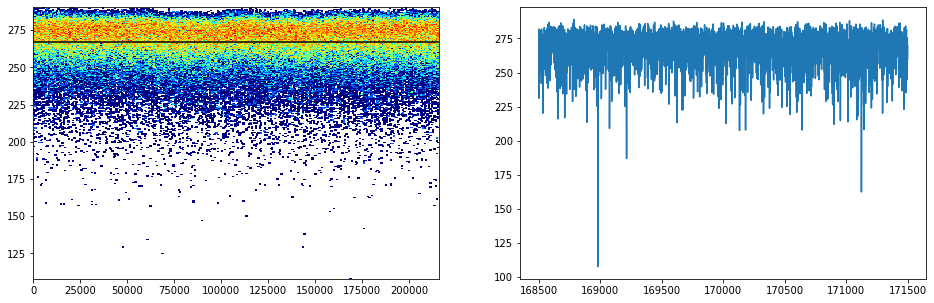

In [7]:
sscore = pca.score_samples(x_minutes)
plt.subplot(121)
plt.hist2d(np.arange(len(sscore)), sscore, bins=(300,500), cmap=plt.cm.jet, norm=mcolors.LogNorm())[0]
plt.plot([0, len(sscore)], np.repeat(pca.score(x_minutes), 2), color='black')

plt.subplot(122)
zoom = 170000
plt.plot(np.arange(zoom-1500,zoom+1500), sscore[zoom-1500:zoom+1500])
anomaly = 168981
print(f"The log likelihood at {anomaly} is {sscore[anomaly]}.")


The black line in the graph above is the average log-likelihood, so points near or above the black line are "typical". If we are looking for anomalies, points with a log-likelihood of under 200 or 150 are where the suspects are. Note that there must be some reason that the y-axis starts below 125. A careful examination with a magnifying glass shows a small blip sitting on the x-axis around x=170,000. In fact, that is why the graph on the right zooms in there, to show the culprit in detail.

Zooming in further, we can locate the anomaly precisely at 168981. If we plot the data for that and the previous and next minute, we can see that the fit is not very good in the middle interval.

### Nugget 6. Use Hist2d to Plot Lines

Until now, we had been using `plt.plot` to plot graphs of our time series. Although `x` had nearly 13 million points, while the screen image doesn't have much more than around 1000 points, there seem to be thousands of points that are going to be plotted right on top of each other. 

This has three problems.

* The plot actually saves each of the 12 million points used to generate it, wasting about 100 megabytes for each plot.
* The plot takes a long time to render because it has to draw each of those points on the screen
* The plot gives no indication of where there is only one point, and where one point has been drawn over a thousand times

When your time series has a very large number of points, a better way that avoids all these problems is to draw a histogram. This only draws points, instead of connecting them with lines. It colors them by the number of times the point is hit. The darker colors indicate only one point, while the brighter ones have a lot of hits.

In Line 8 above, you can see that we have used the histogram feature to draw the left plot.

#### Sub-nugget 6.1 Use Log Intensities to Capture a Large Range

A plain histogram plots the color intensity based on the number of points that are plotted on top of each other. Since this number ranges from 1 to 1000 or so, the range is so large that colors will not distinguish features very clearly. In such a situation, the addition of the word `norm=mcolors.LogNorm()` in line 8, makes it so that larger numbers are compressed, while smaller number get more room in the color-space. So, for example, there will be as much difference in the colors between 3 and 6 as between 300 and 600.

Usually this is the effect that we want. Try out both with and without to see what looks better to you.

### Anlayzing the anomaly

The following graph shows a three-minute interval, with the worst case anomaly in the center, and one minute intervals on either side. Looking at the approximations, we can see that the 1-component approximation is just a flat line at the average, the 2-component captures the slope, while the 3-component approximation is somewhat like a quadratic fit. The pattern in the anomalous entry looks much like a cubic, and hence can't be approximated well by these.

There does not appear to be anything very unusual here.

Text(0.5, 1.0, 'Examining the most Anamolous Interval')

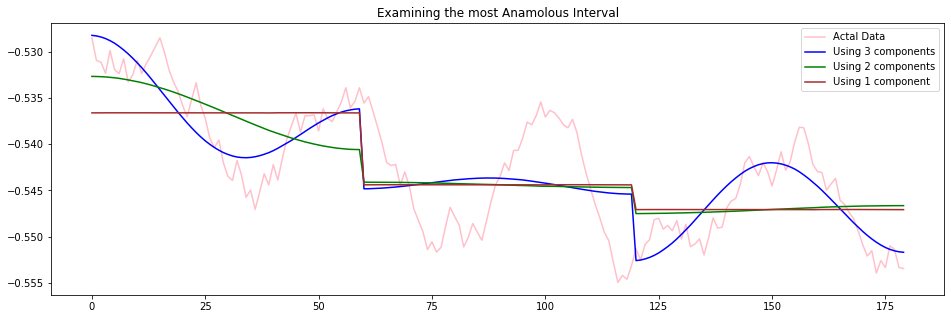

In [8]:
anomaly = 168981
plt.plot(x[(anomaly-1)*60:(anomaly+2)*60], color="pink", label="Actal Data")
plt.plot(reconstructed_x3[(anomaly-1)*60:(anomaly+2)*60], color="blue", label="Using 3 components")
plt.plot(reconstructed_x2[(anomaly-1)*60:(anomaly+2)*60], color="green", label="Using 2 components")
plt.plot(reconstructed_x1[(anomaly-1)*60:(anomaly+2)*60], color="brown", label="Using 1 component")
plt.legend()
plt.title("Examining the most Anomalous Interval")

## Overlapping Windows

As can be seen in the previous graphs, the reconstructed data has jumps at every minute. This is because the variable `x_minutes` broke rows at every 60th second, so the first row is `x[0:60]`, the next is `x[60:120]` and so on. At the end, it had `nrows//60` rows total, so the total size of the `x_minutes` matrix was the same as the size of `x`.

If instead we used overlapping rows so that the first row is `x[0:60]`, the next is `x[1:61]`, and so on, we would get many more rows. In fact the size of the resulting matrix would be nearly 60 times the size of `x`, which would put a strain on the memory.

### Nugget 7. Stride Tricks for overlapping windows

There is a very cute and useful technique hidden inside numpy (for a very good reason which we will mention soon). It is called `stride_tricks` (documented [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.stride_tricks.as_strided.html)). Normally, all `numpy` arrays are 1-dimensional. Multidimensional arrays are stored as a 1-dimensional list of numbers, and then a separate track is kept of the size of each of the dimensions, so that we can calculate the offset of any number.

Every array has a `shape` and a `stride`. The shape gives the number of elements in each dimension. The stride gives the number of bytes to move to go to the next element in that dimension. For example, in a plain 2-dim matrix `x` with `x.shape = (n,m)`, the `stride` of `x` would typically be `(8*m, 8)`, indicating that from the starting element `x[0,0]`, we would find `x[0,1]` located exactly 8 bytes later, and `x[0,2]` would be 8 bytes after that (because a `dtype` of `float` takes 8 bytes to store a number). After `m` such numbers, we have complete a row, so we can start storing the next row. This means that to go from `x[0,0]` to `x[0,1]` we need to take a stride of `8*m` bytes.

If we play with these strides we can make very unusual arrays. So unusual that writing to them can have very confusing effects (see example A below). So unusual that you can crash your program by accidentally writing in areas where you shouldn't. But used carefully, this is a very useful trick.

**Example A:** If `a.shape = (3,4)` and `a.strides =(0,0)` then `a` looks to all the world as if it has 3 rows and 4 columns, but whichever of these 12 numbers you refer to, the stride calculations all send you to the same byte location. There is only has one number. If you set any location, all the number of the matrix change to that number.

**Example B:** consider the array made by `b = np.arange(15).reshape(3,5)`. If we change the shape to `(3,3)` and the strides to `(5*8, 8)` then this would become a 2-dimensional array with three columns which are the diagonals of `b`. Since we are not sure exactly what `dtype` the `b` array has, instead of a setting `strides` to `(40, 8)` it would be better to set it to `(5*b.strides[1], b.strides[1])`.

**Example C** What we want to do is to take an 1-dim array, and make its overlapping windows into rows. To do this we set its strides to be `(8, 8)`. Instead of explaining, just look at what this does to the array.

Note that `x.strides` is not a numpy array. It is a plain python immutable tuple.


In [9]:
print("Example A:")
a = np.array([5])
a_strided = np.lib.stride_tricks.as_strided(a, (3,4), (0,0))
print("    A 3x4 matrix consisting of just one number:")
print(a_strided)
a_strided[2,3] = 2
print("    After changing only one number of the matrix:")
print(a_strided)

print("\nExample B:")
b = np.arange(15).reshape(3,5)
print("    The original matrix:")
print(b)
b_strided = np.lib.stride_tricks.as_strided(b, (3,3), (6*b.strides[1], b.strides[1]))
print("    The matrix of its diagonals:")
print(b_strided)
print("    The original matrix after setting one of the columns of the diagonal matrix to -1")
b_strided[:,1] = -1
print(b)

print("\nExample C:")
c = np.arange(10)
c_window = 5
print("    The original 1-dim matrix")
print(c)
c_overlap = np.lib.stride_tricks.as_strided(c, (len(c) - c_window + 1, c_window), (c.strides[0], c.strides[0]))
print("    Overlapping windows of size 5")
print(c_overlap)


Example A:
    A 3x4 matrix consisting of just one number:
[[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]
    After changing only one number of the matrix:
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]

Example B:
    The original matrix:
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
    The matrix of its diagonals:
[[ 0  1  2]
 [ 6  7  8]
 [12 13 14]]
    The original matrix after setting one of the columns of the diagonal matrix to -1
[[ 0 -1  2  3  4]
 [ 5  6 -1  8  9]
 [10 11 12 -1 14]]

Example C:
    The original 1-dim matrix
[0 1 2 3 4 5 6 7 8 9]
    Overlapping windows of size 5
[[0 1 2 3 4]
 [1 2 3 4 5]
 [2 3 4 5 6]
 [3 4 5 6 7]
 [4 5 6 7 8]
 [5 6 7 8 9]]


We are going to go with the example C above, to create an array `xov` of overlapping windows. This is an enormous array, with shape `(12960000-59, 60)`, but it actually takes no extra space, because it is just sharing the space with the already existing `x`. In fact, every element of `xov` maps to an element of `x` by the simple formula

$$ \texttt{xov[i,j]} = x_{i+j} \quad\mbox{ for $i<n-\texttt{ncol}+1$ and $j<60$.} $$

If we ever try to copy `xov`, the size would suddenly become the full size of `60 * 12959941 * 8` bytes, roughly 6.2 Gigabytes.

We will try to do a PCA, but open up a `Task Manager` window on the side, to watch the memory.
<img src="TaskManager.png" width=600>


In [9]:
ncol = 60
xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
print(xov.shape)
%time pca = PCA(n_components=3).fit(xov)

ev = pca.explained_variance_ratio_
print("Explained variance:", ev)
print("Cumulative Unexplained variance:", 1 - np.cumsum(ev))


(12959941, 60)
Wall time: 1min 25s
Explained variance: [9.99988191e-01 7.19536395e-06 1.79127817e-06]
Cumulative Unexplained variance: [1.18090871e-05 4.61372316e-06 2.82244499e-06]


My plan had been to consider even larger moving windows, for example 300 (for a 5 minute window) or even 3600 (for an hour window), but as we can see from the above statistics, at 60 seconds, we hit the top of the 16 GB memory, and it took over 1 minute to do the computations. One of my constraints is that this computation needs to be done interactively, so we have a maximum of 1 to 3 seconds before user annoyance sets in.

It is evident that somewhere along the way, PCA tries to make a copy of the `x` array, and nearly throws a memory bomb.

So how can we reduce its memory footprint?

And how can we speed it up?

## Idea 2

PCA is really a very simple procedure (in terms of matrices). Given a matrix `xov`,

    x0 = xov - np.mean(xov, axis=0)
    xtx = x0.T @ x0
    scipy.linalg.eigh(xtx, eigvals=(ncol-2, ncol-1))

There are three steps.

1. Subtract the mean from each column.
2. Compute the matrix product of `x.T` and `x`, where `x.T` refers to the transpose of `x`. (more on this later)
3. Compute the eigenvalues and eigenvectors of the product. `eigh` is the preferred routine here, because `xtx` is symmetric. **Warning** there is a `numpy.linalg.eigh` and a `scipy.linalg.eigh` and they differ slightly. The `scipy` version allows the `eigvals=` parameter which makes it go faster because it only computes the few specified eigenvalues and their eigenvectors.

But computing `x0` gets rid of all the compaction we got from `stride_tricks`.

## Idea 3

Since all the columns are nearly identical, they all have ***nearly*** the same mean, so if we center the `x` before we make `xov`, we will be nearly correct:

    x -= np.mean(x)
    xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
    xtx = xov.T @ xov
    scipy.linalg.eigh(xtx, eigvals=(ncol-2, ncol-1))

This is an approximation to the exact answer, but the approximation is very small. Also the answer does not have any *exact* significance. It is really an approximate question that is being asked.

But, when we try it below, you can see we still have memory issues.

### Mini-Nugget 7.1

Note that since `x` and `xov` share their data, once I subtract the mean from `x`, it automatically gets subtracted from `xov`, so we don't have to do line 2 below. On the other hand, that is a trivial saving of time, and can be potentially very confusing to the reader (or yourself a few days later), so it is best to either leave the full statement there, or at least a comment as below.


In [16]:
x -= np.mean(x)
# no needed to repeat the next line because x and xov share their data
# xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
%time xtx = xov.T @ xov
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))


Wall time: 1min 8s
Wall time: 0 ns
Explained Variance: [9.99988191e-01 7.19536398e-06 1.79127818e-06]


The time is being used almost entirely in the matrix multiplication. Fortunately, there are other ways to multiply matrices, so we can see if we can improve on this.

## Idea 4

**Einstien Summation** notation is an amazingly compact way to express all kinds of "Tensor" operations, which include matrix multiplications as well as matrix transpose. Without going into too much detail, a string describes the operation that you want to do. If there are multiple arrays, the indices to each array are separated by commas in the string. Repeated indices indicate summation over that index.

So `a = np.einsum("ki,kj", x, x)`, does the computation:
$$a_{i,j} = \sum_{k} x_{k,i} x_{k,j} $$
When we try this, it stays within memory limits and is faster, although not fast enough for comfortable interactive use.

The output can be converted to `explained_variance` and other scores without much difficulty or computation, but right now we are focused on getting the speed up, so we defer that to a later stage.

Notice that the bottleneck is still the matrix multiplication speed.

In [11]:
x -= np.mean(x)
xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
%time xtx = np.einsum("ki,kj", xov, xov)
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))

Wall time: 31.3 s
Wall time: 1.14 s
Explained Variance: [9.99988191e-01 7.19536393e-06 1.79127816e-06]


Ok, that reduced the time of multiplication by a factor of two, but it is still substantial.

##  Clever Idea 5

Another flashbulb moment! We have already made one approximation. How about another one?

Looking at the formula in Idea 4, you can see that `xtx[i,j]` is exactly the dot product of `xov[:,i]` and `xov[:,j]`. An approximation is that, if `i<=j` the dot product of `xov[:,0]` and `xov[:,j-i]` should be nearly the same. Because `xov[:,i]` is just `xov[:,0]` shifted by `i` places. Similarly, `xov[:,j]` is just `xov[:,j-i]` shifted by the same `i` places. So except for some of the terms at the ends of the vector, the bulk of the sum should be identical.

So, instead of computing the dot product of every column with every other column, we can compute the dot product of column 0 with every other column, and then fill in the rest of the matrix. Suddenly we have converted 3600 dot products into only 60.

Another interesting fact is that the `eigh` function expects a symmetric matrix, so it only picks values from the lower triangular part, and ignores the upper triangular entries of `xtx`. This makes our task a bit easier to fill in the `xtx` matrix.

In [12]:
x -= np.mean(x)
xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
xtx = np.zeros([ncol, ncol])
%time xtx[:,0] = np.einsum("i,ij", xov[:,0], xov)
for col in range(1,ncol):
    xtx[col:, col] = xtx[:-col,0]
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))

Wall time: 479 ms
Wall time: 0 ns
Explained Variance: [9.99988193e-01 7.19378637e-06 1.79113793e-06]


SUCCESS! we have a fast and low memory version for the first time. This is 60 times faster than before. The numbers are not the most accurate, but the errors will be small, especially with the huge length of data that we have.

But we are intrepid and will not be stopped. We will defeat our successes with further successes.

## Idea 6

Because of our approximation in idea 5, the `xtx` matrix has become not just symmetric but Toeplitz! Every diagonal just carries the same number. Since `numpy` has some special commands to create Toeplitz matrices, we can replace the loop in lines 5 and 6 of Idea 5, with a simple statement:
`xtx = scipy.linalg.toeplitz( np.einsum(...) )`
This will take that result and fill out the matrix.
This does not accomplish much in terms of memory or speed, but does make the program shorter and simpler to read.

In [13]:
x -= np.mean(x)
xov = np.lib.stride_tricks.as_strided(x, (len(x) - ncol + 1, ncol), x.strides + x.strides)
%time xtx = la.toeplitz(np.einsum("i,ij", xov[:,0], xov))
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))

Wall time: 467 ms
Wall time: 0 ns
Explained Variance: [9.99988193e-01 7.19378637e-06 1.79113793e-06]


As expected, the speed is unchanged, but the program is rather elegant (if I do say so myself).

## Idea 7

After all this effort to compute `xtx` in a fast way, I just remembered that dot products of moving windows are exactly what convolutions are all about. Numpy has a `np.convolve`, function, but convolutions usually reverse one array before dot product with the other array. There is a better function for our needs called `np.correlate`, which has nothing to do with statistical correlations, and in fact is just a convolution without the reverse step.
Here the moving windows are not overlapping windows in the rows of our `xov`. Instead they are the columns of `xov`.
So here is what `np.correlate(x, x[:-ncol+1]` does:

It lays the two 1-dim vectors side by side. Since they are different sized, it matches the starting location of 0 for both of them. It then computes the dot product of the portion where both are defined, getting `x[:-n+1] . x[:-n+1]`, which is exactly `xtx[0,0]`. It then slides the smaller vector by 1, and computes another dot product where the two vectors are both defined, obtaining `xtx[1,0]`. It continues this way until the end of both vectors align after which it stops.

This is exactly what we were doing with `einsum`, but this `correlate` has been optimized for exactly this behavior so it should be faster. Not only that, we never have to create the `xov` array, so the program looks extremely elegant.



In [14]:
x -= np.mean(x)
%time xtx = la.toeplitz(np.correlate(x, x[:-ncol+1]))
%time e_val, e_vec = la.eigh(xtx, eigvals=(ncol-3, ncol-1))
print("Explained Variance:", e_val[::-1] / np.trace(xtx))


Wall time: 203 ms
Wall time: 0 ns
Explained Variance: [9.99988193e-01 7.19378639e-06 1.79113794e-06]


We just doubled the speed of an already very fast algorithm, and this is about as good as it gets.

## Idea 8

We made two approximations, one in idea 3, and one in idea 5. The first one has a very small effect, and we will ignore it. The Toeplitz approximation, on the other hand, has noticeable small errors in our artificial example. In my real example, this effect becomes quite significant.

It is not difficult to account for the approximation errors. We simply need to do careful accounting of the exact difference between our approximation and the correct answer. Line 3 of the code in idea 4 (before the approximation) was

    xtx = np.einsum("ki,kj", xov, xov)

If we let $c=\texttt{ncol}$ and $n' = n - c$, then for $0\le j \le i < c$

$$ \texttt{xtx[i,j]}
    = \sum_{k=0}^{n'} \texttt{xov[$k$,i] xov[$k$,j]}
    = \sum_{k=0}^{n'} x_{k+i} x_{k+j} 
$$

The approximation in idea 5, created a Toeplitz approximation to `xtx`, which we will call `toe`. The lower triangular elements of this matrix (where i$\ge$j) are

$$ \texttt{toe[i,j]} = \texttt{xtx[i-j,0]} = \sum_{k=0}^{n'} x_{k+i-j} x_{k} $$

which clearly shows that all the diagonals have the same value. The error introduced by this approximation $\Delta$ can be written as

$$ \Delta_{i,j} = \texttt{toe[i,j]} - \texttt{xtx[i,j]}
    = \sum_{k=0}^{n'} x_{k+i-j} x_{k} - \sum_{k=0}^{n'} x_{k+i} x_{k+j}
    = \sum_{k=0}^{n'} x_{k+i-j} x_{k} - \sum_{k=j}^{j+n'} x_{k+i-j} x_{k}
    = \sum_{k=0}^{j-1} x_{k+i-j} x_{k} - \sum_{k=n'+1}^{j+n'} x_{k+i-j} x_{k}
$$

This suggests several possible ways of implementation. We will have to see which one is the most efficient.

**Plan A: Incremental method** Observe that $\Delta_{i,0} = 0$ and for $0<j\le i<c$
$$ \Delta_{i,j} = \Delta_{i-1,j-1} + x_{i-1} x_{j-1} - x_{i+n'} x_{j+n'}
$$
The first column of `xtx` is exactly the same as `toe`.
Each successive column can be computed from the immediately previous column by using the equation above. This would normally be a satisfactory solution, but it would require a python loop, and according the dogma, Python loops should be avoided at all costs, so we try a more complex, but pure numpy method.

**Plan B: Matrix method** Define the first row of `xov` (shifted by 1) to be $\mathbf{x_f} = [0, x_0, x_1, \ldots, x_{c-2}]$, and the last row of `xov` (also shifted by 1) to be $\mathbf{x_l} = [0, x_{n'+1}, x_{n'+2}, \ldots, x_{n-1}]$. Then the $i,j^\text{th}$ entry of the matrix $\mathbf{x_f}^T \mathbf{x_f}$ is simply $x_{i-1} x_{j-1}$, and in $\mathbf{x_l}^T \mathbf{x_l}$ it is $x_{n'+i} x_{n'+j}$. So we can write the incremental equation as

$$ \Delta_{i+1,j+1} = \Delta_{i,j} 
   + [\mathbf{x_f}^T \mathbf{x_f}]_{i+1,j+1} - [\mathbf{x_l}^T \mathbf{x_l}]_{i+1,j+1} $$

This expresses the error in the $\Delta_{i+1, j+1}$ in terms of the $\Delta{i,j}$. We can accumulate all the terms to get the formula

$$ \Delta_{i+1,j+1} = \Delta_{i-j,0} + \sum_{k=0}^{j+1} [\mathbf{x_f}^T \mathbf{x_f} - \mathbf{x_l}^T \mathbf{x_l}]_{i-j+k,k} $$

While numpy has cumulative sum functions for columns or rows, it does not do cumulative sums along diagonals. But we can use stride tricks once again to make the diagonals into columns similar to example B in the nugget about stride tricks. Starting from a square $n$ by $n$ matrix, reshape it as a $n-1$ by $n+1$ matrix. The numpy `reshape` method won't work, because the new matrix is one element smaller than the original square, but stride tricks won't complain.

In this new matrix, the lower sub-diagonals can be found as columns, as can be seen in the code shown below.


In [6]:
print("\nExample B:")
nb = 5
a = np.arange(nb*nb).reshape(nb,nb)
print("    The original matrix:")
print(a)
print()
b = np.lib.stride_tricks.as_strided(a.reshape(-1,1)[1], (nb-1,nb+1), ((nb+1)*a.strides[1], a.strides[1]))
print("    The matrix of its diagonals:")
print(b)
print()
print("    The lower sub-diagonals")
for d in range(1,nb):
    print(b[d-1:, -d-1])
    
print("    Sum lower sub-diagonals inplace")
b = np.tril(a)
b[:,0] = 0     # our matrix has zeros in first column and is lower triangular
c = np.lib.stride_tricks.as_strided(b.reshape(-1,1)[1], (nb-1,nb+1), ((nb+1)*b.strides[1], b.strides[1]))
c.cumsum(axis=0, out=c)
print(b)


Example B:
    The original matrix:
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]

    The matrix of its diagonals:
[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]
 [13 14 15 16 17 18]
 [19 20 21 22 23 24]]

    The lower sub-diagonals
[ 5 11 17 23]
[10 16 22]
[15 21]
[20]
    Sum lower sub-diagonals inplace
[[ 0  0  0  0  0]
 [ 5  6  0  0  0]
 [10 16 18  0  0]
 [15 26 33 36  0]
 [20 36 48 56 60]]


For a speed and accuracy comparison, we try both `plan A` and `plan B`. Oddly enough, `plan A`, despite the loop turns out to be faster, even for fairly large values of `n`. This is nice, because `plan A` has simpler code.

In [35]:
def planA(x, n):
    xtx = np.zeros([n,n])
    xtx[:,0] = np.correlate(x, x[:-n+1])
    xlast  = x[-n+1:][:, None]
    xfirst = x[:n-1] [:, None]
    delta = xlast @ xlast.T - xfirst @ xfirst.T
    for i in range(1,n):
        xtx[i:, i] = xtx[i-1:-1, i-1] + delta[i-1, i-1:]
    return xtx

def planB(x, n):
    xlast  = np.concatenate([[0], x[-n+1:]])[:, None]
    xfirst = np.concatenate([[0], x[:n-1]]) [:, None]
    delta = xlast @ xlast.T - xfirst @ xfirst.T
    xtx = la.toeplitz(np.correlate(x, x[:-n+1]))
    delta = np.tril(delta)
    ds = delta.strides[1]
    b = np.lib.stride_tricks.as_strided(delta.reshape(-1,1)[1], (n-1,n+1), ((n+1)*ds, ds))
    b.cumsum(axis=0, out=b)
    xtx += delta
    return xtx

# we make the series shorter and the columns longer to
# spend more time in the error correction.
%timeit xtxA = planA(x[:10000], 6000)
%timeit xtxB = planB(x[:10000], 6000)
print("Avg. Relative Error:", np.nanmean(np.abs(np.tril( (xtxB-xtxA)/xtxA ))))


833 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.11 s ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


C:\Users\Arif\AppData\Local\conda\conda\envs\python3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


Avg. Relative Error: 1.0070293902085985e-15


We have wrapped the code up in a function called `autoPCA` in the same sense as `autocorrelation`. 
The time for `n=60` went up from 203 ms for an approximate solution to 233 ms for a more accurate one.

With this, we can now do much larger problems, for example the timing for n=3600 is only around 15 seconds!

0 60 0.25703989999965415 [9.99988454e-01 7.03534675e-06 1.75144227e-06]
1 120 0.4441490999997768 [9.99976849e-01 1.41134128e-05 3.51099084e-06]
2 300 1.0565753000000768 [9.99941942e-01 3.53809362e-05 8.82695611e-06]
3 600 1.9888584999998784 [9.99883791e-01 7.06979487e-05 1.77061770e-05]
4 1200 3.9806692999995903 [9.99768013e-01 1.40604006e-04 3.56797475e-05]
5 2400 8.607651799999985 [9.99540525e-01 2.75936143e-04 7.13045501e-05]
6 3600 15.185312499999782 [9.99314489e-01 4.12471767e-04 1.03750856e-04]
7 7200 35.28202080000028 [9.98639627e-01 8.19331002e-04 2.08605769e-04]
8 14400 107.49663989999999 [9.97304349e-01 1.62415033e-03 4.07172164e-04]


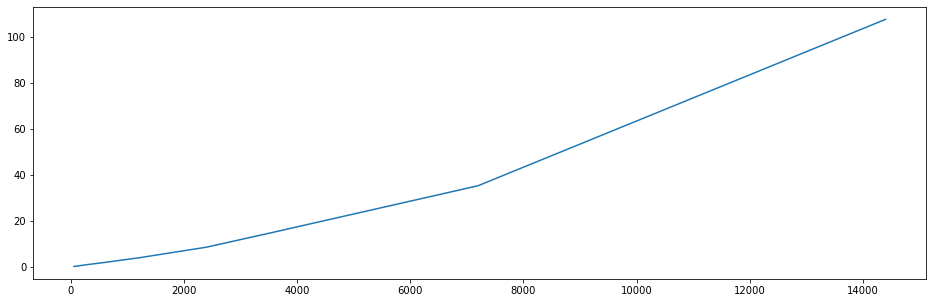

In [36]:
def autoPCA(x, n, k, approx=False, **args):
    """
    x : 1-dimensional array
    k : the number of highest eigenvalues/eigenvectors needed < n
    n : the size of the overlapping window
    approx : don't make minute edge effect corrections for minor improvements in accuracy
    returns the explained variance and the eigenvectors
    """
    x -= np.mean(x)
    if approx:
        xtx = la.toeplitz(np.correlate(x, x[:-n+1]))
    else:
        xtx = np.zeros([n,n])
        xtx[:,0] = np.correlate(x, x[:-n+1])
        xlast  = x[-n+1:][:, None]
        xfirst = x[:n-1] [:, None]
        delta = xlast @ xlast.T - xfirst @ xfirst.T
        for i in range(1,n):
            xtx[i:, i] = xtx[i-1:-1, i-1] + delta[i-1, i-1:]
    ev = la.eigh(xtx, eigvals=(n - k, n - 1), **args)
    if isinstance(ev, np.ndarray):
        return ev[::-1]/np.trace(xtx)
    else:
        return (ev[0][::-1]/np.trace(xtx), ev[1])

import time
nlist = [60, 120, 300, 600, 1200, 2400, 3600, 7200, 14400]
timing = np.empty_like(nlist, dtype=float)
for n, ncol in enumerate(nlist):
    timing[n] = 0.0 - time.perf_counter()
    ev = autoPCA(x, ncol, 3, eigvals_only=True, overwrite_a=True, check_finite=False)
    timing[n] += time.perf_counter()
    print(n, ncol, timing[n], ev)

plt.loglog(nlist, timing, 'o-')

This result is amazing. In 15 seconds, we were able to do a window size of 3600 seconds (1 hour!), where initially, a size of more than 60 seconds consumed all our resources. Just goes to show that persistence can (sometimes) pay off.

## Idea 9

Since we are looking for the eigenvalues of a Toeplitz matrix, there may be better/faster methods designed to take advantages of special features of Toeplitz matrices. For eigen-values often there is a tradeoff between fast and precise. My quick search turned up many papers, but no implementations. At this point, this is good enough for me, but someone may want to take it further. (One reference was by William F Trench [here](http://ramanujan.math.trinity.edu/wtrench/research/papers/TRENCH_TN_12.PDF))

## Postscript

Now the only thing that remains to explain is why it took me four days to write eight lines of code. 

## Request for a Multi-dimensional version

The above code was for a single feature. Just as autocorrelation can be done for multiple features, computing `auto-` and `cross-` `correlations`, we can try and do the same here.

We start with a dataframe $M$ of $c=3$ columns, and $r$ rows. As before, we now construct 3 artificial series for a test case.


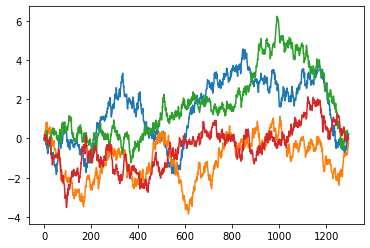

In [3]:
nrows = 5*30*24*60*60
ncols = 4
np.random.seed(2)
x = np.cumsum(rnd([nrows, ncols])-0.5, axis=0)
x = np.cumsum(x*0 + (rnd([nrows, ncols])-0.5)*50, axis=0) * 1e-4
x = x - (np.arange(nrows)[:,None]/nrows) @ x[-1, :][None, :]
df = x.copy()
plt.plot(x[::10000,:])


The data frame looks like

$$ M = \left[\begin{array}{ccc}
x_0 & y_0 & z_0 \\
x_1 & y_1 & z_1 \\
\vdots & \vdots & \vdots \\
x_r & y_r & z_r \\
\end{array}\right]
$$

We want windows of length $w$, so the total number of complete windows that can fit in $r$ rows is $m=r-w+1$. 
A "window" of 5 rows now contains 15 items, and to consider them as a linear vector,
we can make a matrix of windows (where each row is a complete window) as before, by:

$$ X = \left[\begin{array}{cccc|cccc|cccc}
x_0 & x_1 & \cdots & x_{w-1} & y_0 & y_1 & \cdots & y_{w-1} & z_0 & z_1 & \cdots & z_{w-1} \\
x_1 & x_2 & \cdots & x_{w}   & y_1 & y_2 & \cdots & y_w     & z_1 & z_2 & \cdots & z_w \\
\vdots & \vdots & \ddots     & \vdots & \vdots & \vdots     & 
\ddots & \vdots & \vdots & \vdots & \ddots & \vdots \\
x_m & x_{m+1} & \cdots & x_r & y_m & y_{m+1} & \cdots & y_r & z_m & z_{m+1} & \cdots & z_r \\
\end{array}\right]
$$

And now our job is to find $X^TX$.

Instead of jumping to the answer, it is nice to take it in small steps (bigger than before).
The first attempt can be to create a "virtual" array as before. Previously we went from a single column of numbers to a two-dimensional `xov` which we are calling $X$ here, so here we will end up with a three-dimensional `xov`.
The dimensions of `xov` are now $m \times c \times w$. This is really the X array shown above, where each of the three parts are stacked one on top of the other. The first dimension is down the page (hence length $m$), the second dimension is down the stack (length $c=3$) and the third is left to right (length $w$).

The $X^TX$ matrix is just the $cw \times cw$ matrix that is the dot products of every pair of columns in $X$.

The simplest way to express this is using the Einstein notation (for the first time being used in its full Tensor form for which it is indispensable)"

    XTX = np.einsum("ijk,ilm->jklm", xov, xov).reshape([nc*nw, nc*nw])

The result of `einsum` is a four-dimensional matrix, which we convert to a two dimensional array by `reshape`.


In [14]:
def xtx_einstien(df, nw):
    # df is the original dataframe (the M matrix shown above)
    # nw is the number of rows in the window
    x = df - np.mean(df, axis=0)
    nr, nc = x.shape
    sr, sc = x.strides
    nm = nr - nw + 1
    xov = np.lib.stride_tricks.as_strided(x, (nm, nc, nw), (sr, sc, sr))

    xtx = np.einsum("ijk,ilm->jklm", xov, xov)
    return xtx # .reshape([nc*nw, nc*nw])

Let us first examine the structure of $X^TX$. To reduce notation, for this next matrix I will use $x_i$ to refer to the column in the $X$ matrix that starts with $x_i$:

$$
X^TX = \left[\begin{array}{cccc|cccc|cccc}
x_0\cdot x_0 & x_0\cdot x_1 & \cdots & x_0\cdot x_{w-1} & 
x_0\cdot y_0 & x_0\cdot y_1 & \cdots & x_0\cdot y_{w-1} & 
x_0\cdot z_0 & x_0\cdot z_1 & \cdots & x_0\cdot z_{w-1} 
\\
x_1\cdot x_0 & x_1\cdot x_1 & \cdots & x_1\cdot x_{w-1} & 
x_1\cdot y_0 & x_1\cdot y_1 & \cdots & x_1\cdot y_{w-1} & 
x_1\cdot z_0 & x_1\cdot z_1 & \cdots & x_1\cdot z_{w-1} 
\\
\vdots & \vdots & \ddots & \vdots &
\vdots & \vdots & \ddots & \vdots &
\vdots & \vdots & \ddots & \vdots
\\
x_{w-1}\cdot x_0 & x_{w-1}\cdot x_1 & \cdots & x_{w-1}\cdot x_{w-1} & 
x_{w-1}\cdot y_0 & x_{w-1}\cdot y_1 & \cdots & x_{w-1}\cdot y_{w-1} & 
x_{w-1}\cdot z_0 & x_{w-1}\cdot z_1 & \cdots & x_{w-1}\cdot z_{w-1} 
\\
\hline
y_0\cdot x_0 & y_0\cdot x_1 & \cdots & y_0\cdot x_{w-1} & 
y_0\cdot y_0 & y_0\cdot y_1 & \cdots & y_0\cdot y_{w-1} & 
y_0\cdot z_0 & y_0\cdot z_1 & \cdots & y_0\cdot z_{w-1} 
\\
y_1\cdot x_0 & y_1\cdot x_1 & \cdots & y_1\cdot x_{w-1} & 
y_1\cdot y_0 & y_1\cdot y_1 & \cdots & y_1\cdot y_{w-1} & 
y_1\cdot z_0 & y_1\cdot z_1 & \cdots & y_1\cdot z_{w-1} 
\\
\vdots & \vdots & \ddots & \vdots &
\vdots & \vdots & \ddots & \vdots &
\vdots & \vdots & \ddots & \vdots
\\
y_{w-1}\cdot x_0 & y_{w-1}\cdot x_1 & \cdots & y_{w-1}\cdot x_{w-1} & 
y_{w-1}\cdot y_0 & y_{w-1}\cdot y_1 & \cdots & y_{w-1}\cdot y_{w-1} & 
y_{w-1}\cdot z_0 & y_{w-1}\cdot z_1 & \cdots & y_{w-1}\cdot z_{w-1} 
\\
\hline
z_0\cdot x_0 & z_0\cdot x_1 & \cdots & z_0\cdot x_{w-1} & 
z_0\cdot y_0 & z_0\cdot y_1 & \cdots & z_0\cdot y_{w-1} & 
z_0\cdot z_0 & z_0\cdot z_1 & \cdots & z_0\cdot z_{w-1} 
\\
z_1\cdot x_0 & z_1\cdot x_1 & \cdots & z_1\cdot x_{w-1} & 
z_1\cdot y_0 & z_1\cdot y_1 & \cdots & z_1\cdot y_{w-1} & 
z_1\cdot z_0 & z_1\cdot z_1 & \cdots & z_1\cdot z_{w-1} 
\\
\vdots & \vdots & \ddots & \vdots &
\vdots & \vdots & \ddots & \vdots &
\vdots & \vdots & \ddots & \vdots
\\
z_{w-1}\cdot x_0 & z_{w-1}\cdot x_1 & \cdots & z_{w-1}\cdot x_{w-1} & 
z_{w-1}\cdot y_0 & z_{w-1}\cdot y_1 & \cdots & z_{w-1}\cdot y_{w-1} & 
z_{w-1}\cdot z_0 & z_{w-1}\cdot z_1 & \cdots & z_{w-1}\cdot z_{w-1} 
\\
\end{array}\right]
$$

If we now try the Toeplitz approximation that we used above, we find that each of the blocks in the $X^TX$ matrix is itself approximately a Toeplitz matrix, although only the diagonal blocks are symmetric. So in the approximate matrix the first row and column of each block contain distinct entries, which are then copied for the rest of the block.

$$
X^TX \sim \left[\begin{array}{cccc|cccc|cccc}
x_0\cdot x_0 & x_0\cdot x_1 & \ddots & x_0\cdot x_{w-1} & 
x_0\cdot y_0 & x_0\cdot y_1 & \ddots & x_0\cdot y_{w-1} & 
x_0\cdot z_0 & x_0\cdot z_1 & \ddots & x_0\cdot z_{w-1} 
\\
x_1\cdot x_0 & x_0\cdot x_0 & \ddots & x_0\cdot x_{w-2} & 
x_1\cdot y_0 & x_0\cdot y_0 & \ddots & x_0\cdot y_{w-2} & 
x_1\cdot z_0 & x_0\cdot z_0 & \ddots & x_0\cdot z_{w-2} 
\\
\ddots & \ddots & \ddots & \ddots &
\ddots & \ddots & \ddots & \ddots &
\ddots & \ddots & \ddots & \ddots
\\
x_{w-1}\cdot x_0 & x_{w-2}\cdot x_0 & \ddots & x_0\cdot x_0 & 
x_{w-1}\cdot y_0 & x_{w-2}\cdot y_0 & \ddots & x_0\cdot y_0 & 
x_{w-1}\cdot z_0 & x_{w-2}\cdot z_0 & \ddots & x_0\cdot z_0 
\\
\hline
y_0\cdot x_0 & y_0\cdot x_1 & \ddots & y_0\cdot x_{w-1} & 
y_0\cdot y_0 & y_0\cdot y_1 & \ddots & y_0\cdot y_{w-1} & 
y_0\cdot z_0 & y_0\cdot z_1 & \ddots & y_0\cdot z_{w-1} 
\\
y_1\cdot x_0 & y_0\cdot x_0 & \ddots & y_0\cdot x_{w-2} & 
y_1\cdot y_0 & y_0\cdot y_0 & \ddots & y_0\cdot y_{w-2} & 
y_1\cdot z_0 & y_0\cdot z_0 & \ddots & y_0\cdot z_{w-2} 
\\
\ddots & \ddots & \ddots & \ddots &
\ddots & \ddots & \ddots & \ddots &
\ddots & \ddots & \ddots & \ddots
\\
y_{w-1}\cdot x_0 & y_{w-2}\cdot x_0 & \ddots & y_0\cdot x_0 & 
y_{w-1}\cdot y_0 & y_{w-2}\cdot y_0 & \ddots & y_0\cdot y_0 & 
y_{w-1}\cdot z_0 & y_{w-2}\cdot z_0 & \ddots & y_0\cdot z_0 
\\
\hline
z_0\cdot x_0 & z_0\cdot x_1 & \ddots & z_0\cdot x_{w-1} & 
z_0\cdot y_0 & z_0\cdot y_1 & \ddots & z_0\cdot y_{w-1} & 
z_0\cdot z_0 & z_0\cdot z_1 & \ddots & z_0\cdot z_{w-1} 
\\
z_1\cdot x_0 & z_0\cdot x_0 & \ddots & z_0\cdot x_{w-2} & 
z_1\cdot y_0 & z_0\cdot y_0 & \ddots & z_0\cdot y_{w-2} & 
z_1\cdot z_0 & z_0\cdot z_0 & \ddots & z_0\cdot z_{w-2} 
\\
\ddots & \ddots & \ddots & \ddots &
\ddots & \ddots & \ddots & \ddots &
\ddots & \ddots & \ddots & \ddots
\\
z_{w-1}\cdot x_0 & z_{w-2}\cdot x_0 & \ddots & z_0\cdot x_0 & 
z_{w-1}\cdot y_0 & z_{w-2}\cdot y_0 & \ddots & z_0\cdot y_0 & 
z_{w-1}\cdot z_0 & z_{w-2}\cdot z_0 & \ddots & z_0\cdot z_0 
\\
\end{array}\right]
$$

To make this matrix we can't use our friend `numpy.correlate` because it can only handle one-dimensional vectors, but `scipy.signal.correlate`  allows for multi-dimensional signals. If I do the command

    scipy.signal.correlate(M, xov[:,c,0])

The array `xov[:,c,0]` (using the previous notation) is just the $x_0$, $y_0$, or the $z_0$ column depending on if $c$ is 0, 1 or 2. So, for example, when $c=0$ the result is a $w \times c$ matrix consisting of

$$
\left[
\begin{array}{ccc}
x_0 \cdot x_0     & x_0 \cdot y_0     & x_0 \cdot z_0     \\
x_0 \cdot x_1     & x_0 \cdot y_1     & x_0 \cdot z_1     \\
\vdots            & \vdots            & \vdots            \\
x_0 \cdot x_{w-1} & x_0 \cdot y_{w-1} & x_0 \cdot z_{w-1} \\
\end{array}
\right]
$$
 
Note that these are exactly all the entries of the first row (or column of since $X^TX$ is symmetric) of the approximation. If $c=1$ then these are the entries of the first row of the horizontal middle three blocks of the matrix (or the first column of the vertical middle three). Similarly, if $c=2$ we get the first row/column of the last three blocks.

With the first row and column of every block known, and with an assumption of approximately Toeplitz, we can just copy these known values diagonally down to find an approximation to the full `xtx`.


In [46]:
def xtx_approx(df, nw):
    # df is the original dataframe (the M matrix shown above)
    # nw is the number of rows in the window
    x = df - np.mean(df, axis=0)
    nr, nc = x.shape
    sr, sc = x.strides
    nm = nr - nw + 1
    xov = np.lib.stride_tricks.as_strided(x, (nm, nc, nw), (sr, sc, sr))
    
    xtx = np.zeros([nc, nw, nc, nw])
    for j in range(nc):
        cor = spsig.correlate(x, x[:nm, j][:, None], mode='valid').T
        xtx[j,0,:,:] = cor
        xtx[:,:,j,0] = cor
    for i in range(nc):
        for j in range(nc):
            xtx[i,:,j,:] = la.toeplitz(xtx[i,:,j,0], xtx[i,0,j,:])
    return xtx

# These are too slow, so we reduce the data size by a factor of nearly 130
xtx_ein = xtx_einstien(x, 60)
xtx_app = xtx_approx(  x, 60)
dif = xtx_ein - xtx_app
np.mean(np.abs(dif)), np.mean(np.abs(xtx_ein))


(0.2686147905429549, 15.794613443825813)

With proper notation, it is now not difficult to see exactly how to make the approximation exact. The first row and column of each block is exact. The Toeplitz approximation assumes (incorrectly) that in each block $x_{i,j} = x_{i-1,j-1}$.

Note that the four-dimensional `xtx` matrix corresponds to the two dimensional $X^TX$ matrix in a simple way.
`xtx[i,k,j,l]` corresponds to the $(k,l)$ entry in the $(i,j)$ block matrix, and so is equal to the dot product of `xov[i,k,:]` and `xov[j,l,:]`. When either `k` or `l` is zero, the Toeplitz approximation is exact, because this is either the first row or the first column of a block. When they are both non-zero, the difference 
`xov[i,k-1,j,l-1] - xov[i,k,j,l]` is the difference
$$
    \Delta^{i,j}_{k,l} = \mbox{xov}[i,k,j,l] - \mbox{xov}[i,k-1,j,l-1]
    = \sum_{h=0}^m x_{k+h,i} \cdot x_{l+h,j} - \sum_{h=0}^m x_{k-1+h,i} \cdot x_{l-1+h,j}
    = x_{k+m,i} \cdot x_{l+m,j} - x_{k-1,i} \cdot x_{l-1,j}
$$
The Toeplitz approximation assumes that all these $\Delta$s are 0. To get the exact answer, we can compute them and add them back in. Then, if we consider $k$ and $l$ taking values from 1 to $w-1$, we get a $(w-1,w-1)$ matrix of discrepancies
$$
    \Delta^{i,j} = [x_{m+1,i}, \ldots, x_{m+w-1,i}] [x_{m+1,i}, \ldots x_{m+w-1,i}]^T - 
                   [x_{0,i}, \ldots, x_{w-2,i}] [x_{0,i}, \ldots, x_{w-2,i}]^T 
$$
these $x$s are the simple data entries in the original dataframe called $M$ in the start.


In [61]:
def xtx_correl(df, nw, approx=True):
    x = df - np.mean(df, axis=0)
    nr, nc = x.shape
    sr, sc = x.strides
    nm = nr - nw + 1
    xov = np.lib.stride_tricks.as_strided(x, (nm, nc, nw), (sr, sc, sr))

    xtx = np.zeros([nc, nw, nc, nw])
    # to imagine this as 2-dim matrix the first two dims are the row, and the second 2 are the col
    for j in range(nc):
        cor = spsig.correlate2d(x, x[:nm, [j]], mode='valid').T
        xtx[j,0,:,:] = cor
        xtx[:,:,j,0] = cor
    if approx:
        for i in range(nc):
            for j in range(nc):
                xtx[i,:,j,:] = la.toeplitz(xtx[i,:,j,0], xtx[i,0,j,:])
    else:
        for i in range(nc):
            for j in range(nc):
                delta = x[-nw+1:, [i]] @ x[-nw+1:, [j]].T - x[:nw-1, [i]] @ x[:nw-1, [j]].T
                for k in range(1,nw):
                    xtx[i, k:, j, k] = xtx[i, k-1:-1, j, k-1] + delta[k-1:, k-1]
                    xtx[i, k, j, k+1:] = xtx[i, k-1, j, k:-1] + delta[k-1, k:]
    return xtx

xtx_cor     = xtx_correl(x[:10000,:], 60, approx=False)
xtx_cor_app = xtx_correl(x[:10000,:], 60, approx=True)
print(' exact:', np.mean(np.abs(xtx_ein - xtx_cor)), np.mean(np.abs(xtx_ein)))
print('approx:', np.mean(np.abs(xtx_ein - xtx_cor_app)), np.mean(np.abs(xtx_ein)))


 exact: 2.4923917096852932e-14 15.794613443825813
approx: 0.2686147905429467 15.794613443825813


# Final Version

If you don't want to spend the time to read the details above, you can start reading here. It is a brief, complete program and an example illustrating its use.

In summary, here, we 

1. make an artificial dataset with 12.96 million `rows` and 4 `columms`. 
2. We set a `window size` of 60 rows. 
3. For each valid starting row, we take a block of 60 rows from the starting row (a total of 240 numbers)
4. For this block data: now (12.96 million - 59) rows and 240 columns we do a Principal Components analysis. Note that this is a huge matrix, but it is only conceptual, the actual memory requirements, besides the (`rows` $\times$ `columns`) of the input data, are (`columns` $\times$ `window size`)$^2 = 120^2$. That is why it is not difficult to accomodate window sizes of 6000.
5. We extract the top 6 principal components. (no problem to do more except that the graphs get cluttered).
6. We compress the data into its pricipal components, so that each block of 240 numbers is replaced by 6 numbers.
7. We expand the data, back and compare with the original (The errors are less than 1%).

The autoPCA class corresponds roughly to the PCA class.
To really make a **Final** version, there would be many more bells and whistles to add.
Best would be to copy from the actual numpy.PCA.

In under 3 minutes, it computed the Principal Components, transformed (compressed) the data, and did the inverse transform (reexpand) the compressed data, and finally compared it with the original and drew the plots as described in the steps above.

When the window size was multiplied by ten, (changing line `121` from `nwin = 60` to `nwin = 600`), the runtime was 25 minutes (only a factor of 9 increase). Since we are now compressing 2400 points to 6, instead of 240, the relative error increases from 1% to about 5%.


Starting PCA with array shaped: (12960000, 4)
Unexplained Variance: [6.63527113e-01 1.58495454e-01 9.96657114e-02 7.83008667e-02
 1.65769359e-06 1.65314863e-06]


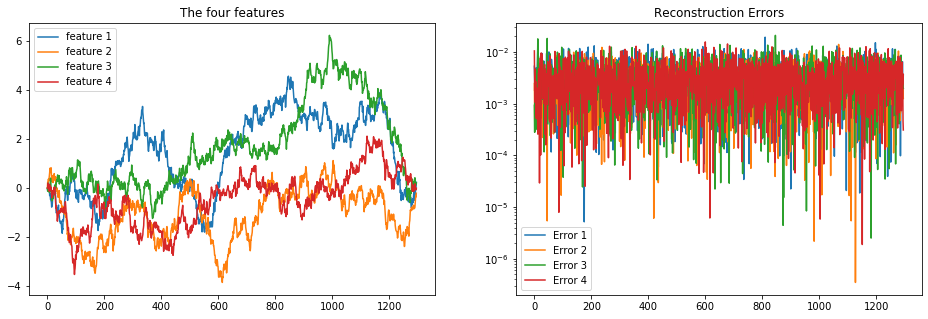

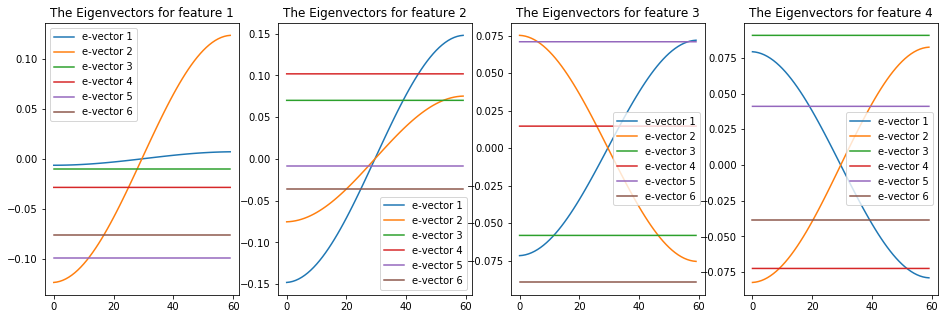

2min 31s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%%timeit -n1 -r 1

import numpy as np
from numpy.random import random as rnd
import scipy
import scipy.linalg as la
import scipy.signal as spsig
from sklearn.decomposition import PCA

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd

class autoPCA:
    def __init__(self, n_components=None, window=1, approx=False, **args):
        """
        x               the data is a 2-dim (r x c) array
        n_components    is the number of prinicipal components to keep
        window          We are trying to compress window x c arrays into components
        eigvals_only    =True
        check_finite    =False
        """
        self.ne = n_components
        self.nw = window
        self.nc = 1
        self.approx = approx
        # args to be passed to eigh
        self.args = args
        self.eval = None
        self.evec = None
        
    def fit(self, x):
        x = x - np.mean(x, axis=0)
        nw = self.nw
        #### Compute xtx
        if x.ndim == 1:
            nc = 1
            if self.approx:
                xtx = la.toeplitz(np.correlate(x, x[:-nw+1]))
            else:
                xtx = np.zeros([nw,nw])
                xtx[:,0] = np.correlate(x, x[:-nw+1])
                delta = x[-nw+1:, None] @ x[None, -nw+1:] - x[:nw-1, None] @ x[None, :nw-1]
                for k in range(1,nw):
                    xtx[k:, k] = xtx[k-1:-1, k-1] + delta[k-1, k-1:]
        elif x.ndim == 2:
            nc = x.shape[1]
            xtx = np.zeros([nc, nw, nc, nw])
            # to imagine this as 2-dim matrix the first two dims are the row, and the second 2 are the col
            for j in range(nc):
                cor = spsig.correlate2d(x, x[:-nw+1, j][:, None], mode='valid').T
                # only doing lower triangular, so
                xtx[j, 0,:j,:] = cor[:j,:]    # rows
                xtx[j:,:, j,0] = cor[j:,:]    # cols
            if self.approx:
                for i in range(nc):
                    xtx[i,:,j,:] = la.toeplitz(xtx[i,:,i,0])
                    for j in range(i):
                        xtx[i,:,j,:] = la.toeplitz(xtx[i,:,j,0], xtx[i,0,j,:])
            else:
                for i in range(nc):
                    # diagonal blocks i==j
                    delta = x[-nw+1:, [i]] @ x[-nw+1:, [i]].T - x[:nw-1, [i]] @ x[:nw-1, [i]].T
                    for k in range(1,nw):
                        xtx[i, k:, i, k] = xtx[i, k-1:-1, i, k-1] + delta[k-1:, k-1]
                    # lower triangular blocks i>j
                    for j in range(i):
                        delta = x[-nw+1:, [i]] @ x[-nw+1:, [j]].T - x[:nw-1, [i]] @ x[:nw-1, [j]].T
                        for k in range(1,nw):
                            xtx[i, k:, j, k] = xtx[i, k-1:-1, j, k-1] + delta[k-1:, k-1]
                            xtx[i, k, j, k+1:] = xtx[i, k-1, j, k:-1] + delta[k-1, k:]
            xtx = xtx.reshape([nw*nc, nw*nc])
        else:
            return None
        self.nc = nc
        #### Compute Eigenvalues (and Eigenvectors)
        self.trace = np.trace(xtx)
        # depending on user args, ev could be a list of two items or an ndarray
        ev = la.eigh(xtx, eigvals=(nw*nc - self.ne, nw*nc - 1), overwrite_a=True, **self.args)
        if isinstance(ev, np.ndarray):
            self.eval = ev[::-1]
            self.evec3d = self.evec = None
        else:
            self.eval = ev[0][::-1]
            self.evec = ev[1]
            self.evec3d = self.evec.reshape(self.nc, self.nw, self.ne)
        return self.eval/self.trace

    # compress
    def transform(self, x):
        if x.ndim == 1:
            # x[nr], evec[nw, ne] -> comp[nr, ne]
            return np.array([np.ravel(spsig.correlate(x, self.evec[:,e], mode='valid')) 
                             for e in range(self.ne)]).T
        elif x.ndim == 2:
            # x[nr, nc], evec3d[nc, nw, ne] -> comp[nr, ne]
            return np.vstack([spsig.correlate2d(x.T, self.evec3d[:,:,e], mode='valid') 
                             for e in range(self.ne)]).T
        else:
            return None
    # expand 
    def inverse_transform(self, comp):
        if x.ndim == 1:
            # comp[nr, ne], evec[nw, ne] -> x[nr, nw]
            return comp @ self.evec.T
        elif x.ndim == 2:
            # comp[nr, ne], evec[nc, nw, ne] -> x[nr, nw, nc]
            return np.einsum("ij,klj->ilk", comp, self.evec3d)
        else:
            return None

if __name__ == "__main__":
    plt.rcParams['figure.figsize'] = [16, 5]
    
    # make random features
    nrows = 5*30*24*60*60
    ncols = 4
    ncomp = 6
    nwin = 60
    np.random.seed(2)
    x = np.cumsum(rnd([nrows, ncols])-0.5, axis=0)
    x = np.cumsum(x*0 + (rnd([nrows, ncols])-0.5)*50, axis=0) * 1e-4
    x = x - (np.arange(nrows)[:,None]/nrows) @ x[-1, :][None, :]
    plt.plot(x[::10000,:])

    # do a PCA fit - compress - expand - compare
    print("Starting PCA with array shaped:", x.shape)
    a = autoPCA(n_components=ncomp, window=nwin, eigvals_only=False, check_finite=False)
    ev = a.fit(x)
    y = a.transform(x)
    z = a.inverse_transform(y[::nwin])
    z = np.ravel(z) if z.ndim == 2 else z.reshape(-1,a.nc)
    print("Unexplained Variance:", ev)

    # show results
    plt.subplot(121)
    plt.title("The four features")
    plt.plot(x[::10000,:])
    plt.legend([f"feature {i}" for i in range(1,5)])
    
    plt.subplot(122)
    plt.title("Reconstruction Errors")
    plt.semilogy(np.abs(x-z)[::10000,:])
    plt.legend([f"Error {i}" for i in range(1,5)])
    plt.show()

    for feat in range(4):
        plt.subplot(141+feat)
        plt.title(f"The Eigenvectors for feature {feat+1}")
        plt.plot(a.evec3d[feat,:,:])
        plt.legend([f'e-vector {i}' for i in range(1,7)])
    plt.show()
